# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

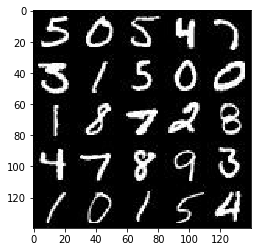

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

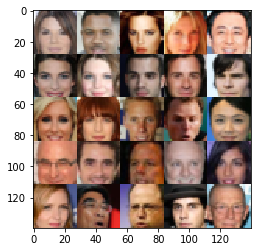

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='leanring_rate')

    return inputs, z_data, learn_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3 for celeba and 28x28x1 for mnist
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha= 0.2

    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xoutput_dim now
        
        out = tf.tanh(logits)
        
        return out
        

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

  
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    out_channel_dim = data_shape[3]
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    steps = 0
    data_image_mode = 'L' if out_channel_dim == 1 else 'RGB'
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model
                batch_images *= 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i +1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 9, input_z, out_channel_dim, data_image_mode)
                    
        show_generator_output(sess, 9, input_z, out_channel_dim, data_image_mode) 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

1
Epoch 1/2... Discriminator Loss: 0.0014... Generator Loss: 9.0352
Epoch 1/2... Discriminator Loss: 4.5081... Generator Loss: 0.0116
Epoch 1/2... Discriminator Loss: 1.1835... Generator Loss: 0.5033
Epoch 1/2... Discriminator Loss: 5.4312... Generator Loss: 0.0059
Epoch 1/2... Discriminator Loss: 1.4404... Generator Loss: 0.4793
Epoch 1/2... Discriminator Loss: 1.5864... Generator Loss: 0.2846
Epoch 1/2... Discriminator Loss: 1.8463... Generator Loss: 0.2667
Epoch 1/2... Discriminator Loss: 2.5373... Generator Loss: 9.6085
Epoch 1/2... Discriminator Loss: 1.4219... Generator Loss: 0.4917
Epoch 1/2... Discriminator Loss: 0.9666... Generator Loss: 0.7857


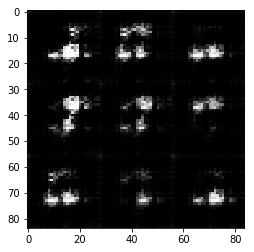

Epoch 1/2... Discriminator Loss: 0.3002... Generator Loss: 1.8888
Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 0.9694
Epoch 1/2... Discriminator Loss: 0.3217... Generator Loss: 3.3893
Epoch 1/2... Discriminator Loss: 0.8353... Generator Loss: 1.8674
Epoch 1/2... Discriminator Loss: 1.4722... Generator Loss: 3.8826
Epoch 1/2... Discriminator Loss: 1.1797... Generator Loss: 0.5446
Epoch 1/2... Discriminator Loss: 1.2457... Generator Loss: 2.0145
Epoch 1/2... Discriminator Loss: 0.9424... Generator Loss: 2.5500
Epoch 1/2... Discriminator Loss: 1.3694... Generator Loss: 0.3795
Epoch 1/2... Discriminator Loss: 1.0609... Generator Loss: 0.7251


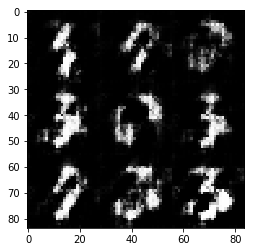

Epoch 1/2... Discriminator Loss: 1.6642... Generator Loss: 0.3020
Epoch 1/2... Discriminator Loss: 1.4221... Generator Loss: 0.4212
Epoch 1/2... Discriminator Loss: 1.2479... Generator Loss: 0.5920
Epoch 1/2... Discriminator Loss: 1.0263... Generator Loss: 2.5567
Epoch 1/2... Discriminator Loss: 1.2659... Generator Loss: 0.9537
Epoch 1/2... Discriminator Loss: 1.2589... Generator Loss: 0.7274
Epoch 1/2... Discriminator Loss: 1.4179... Generator Loss: 1.3602
Epoch 1/2... Discriminator Loss: 1.2773... Generator Loss: 0.5769
Epoch 1/2... Discriminator Loss: 1.1531... Generator Loss: 1.1690
Epoch 1/2... Discriminator Loss: 1.0532... Generator Loss: 1.4072


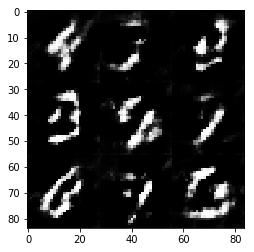

Epoch 1/2... Discriminator Loss: 1.3406... Generator Loss: 1.7314
Epoch 1/2... Discriminator Loss: 1.2351... Generator Loss: 1.2843
Epoch 1/2... Discriminator Loss: 1.0966... Generator Loss: 1.3697
Epoch 1/2... Discriminator Loss: 1.2851... Generator Loss: 0.6892
Epoch 1/2... Discriminator Loss: 1.9477... Generator Loss: 0.2038
Epoch 1/2... Discriminator Loss: 1.3289... Generator Loss: 0.4986
Epoch 1/2... Discriminator Loss: 1.6157... Generator Loss: 0.3218
Epoch 1/2... Discriminator Loss: 1.1066... Generator Loss: 0.9593
Epoch 1/2... Discriminator Loss: 1.2881... Generator Loss: 0.4672
Epoch 1/2... Discriminator Loss: 1.5082... Generator Loss: 0.3584


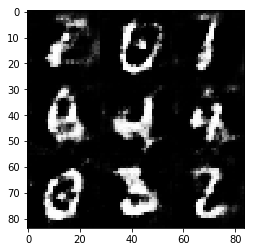

Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 0.5079
Epoch 1/2... Discriminator Loss: 1.2620... Generator Loss: 1.0778
Epoch 1/2... Discriminator Loss: 1.1640... Generator Loss: 0.7481
Epoch 1/2... Discriminator Loss: 1.2631... Generator Loss: 0.5400
Epoch 1/2... Discriminator Loss: 1.5158... Generator Loss: 0.3719
Epoch 1/2... Discriminator Loss: 1.0488... Generator Loss: 0.8775
Epoch 1/2... Discriminator Loss: 1.1498... Generator Loss: 1.3119
Epoch 1/2... Discriminator Loss: 1.2249... Generator Loss: 1.3781
Epoch 1/2... Discriminator Loss: 1.6245... Generator Loss: 0.2826
Epoch 1/2... Discriminator Loss: 1.6673... Generator Loss: 0.2917


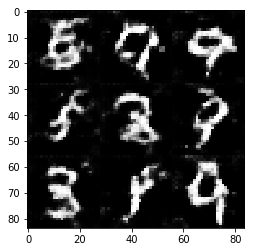

Epoch 1/2... Discriminator Loss: 1.4916... Generator Loss: 0.3459
Epoch 1/2... Discriminator Loss: 1.8953... Generator Loss: 0.2098
Epoch 1/2... Discriminator Loss: 1.6070... Generator Loss: 0.2898
Epoch 1/2... Discriminator Loss: 1.3772... Generator Loss: 0.4540
Epoch 1/2... Discriminator Loss: 1.7600... Generator Loss: 0.2458
Epoch 1/2... Discriminator Loss: 1.1504... Generator Loss: 0.7540
Epoch 1/2... Discriminator Loss: 1.5502... Generator Loss: 0.3133
Epoch 1/2... Discriminator Loss: 1.2246... Generator Loss: 0.5288
Epoch 1/2... Discriminator Loss: 1.4875... Generator Loss: 0.3344
Epoch 1/2... Discriminator Loss: 1.3917... Generator Loss: 0.4695


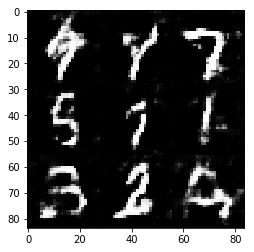

Epoch 1/2... Discriminator Loss: 1.2126... Generator Loss: 1.2697
Epoch 1/2... Discriminator Loss: 1.1464... Generator Loss: 0.9105
Epoch 1/2... Discriminator Loss: 1.0882... Generator Loss: 1.0702
Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 1.0040
Epoch 1/2... Discriminator Loss: 1.3054... Generator Loss: 0.8013
Epoch 1/2... Discriminator Loss: 1.3014... Generator Loss: 1.1892
Epoch 1/2... Discriminator Loss: 1.1337... Generator Loss: 1.0436
Epoch 1/2... Discriminator Loss: 1.8857... Generator Loss: 0.2065
Epoch 1/2... Discriminator Loss: 1.2445... Generator Loss: 0.5990
Epoch 1/2... Discriminator Loss: 1.1979... Generator Loss: 1.1374


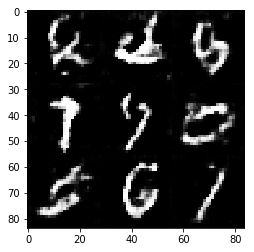

Epoch 1/2... Discriminator Loss: 1.1310... Generator Loss: 0.6462
Epoch 1/2... Discriminator Loss: 1.7654... Generator Loss: 0.2398
Epoch 1/2... Discriminator Loss: 1.1874... Generator Loss: 0.5821
Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 0.3888
Epoch 1/2... Discriminator Loss: 1.5352... Generator Loss: 0.3190
Epoch 1/2... Discriminator Loss: 1.2718... Generator Loss: 0.4972
Epoch 1/2... Discriminator Loss: 2.2854... Generator Loss: 0.1300
Epoch 1/2... Discriminator Loss: 1.1249... Generator Loss: 0.8470
Epoch 1/2... Discriminator Loss: 0.9790... Generator Loss: 0.7487
Epoch 1/2... Discriminator Loss: 0.9403... Generator Loss: 0.9547


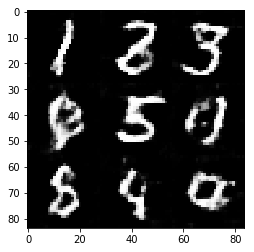

Epoch 1/2... Discriminator Loss: 1.5934... Generator Loss: 0.3607
Epoch 1/2... Discriminator Loss: 1.1495... Generator Loss: 0.6860
Epoch 1/2... Discriminator Loss: 1.3591... Generator Loss: 1.8711
Epoch 1/2... Discriminator Loss: 1.1943... Generator Loss: 0.7099
Epoch 1/2... Discriminator Loss: 2.1258... Generator Loss: 0.1481
Epoch 1/2... Discriminator Loss: 1.2647... Generator Loss: 0.5267
Epoch 1/2... Discriminator Loss: 0.9990... Generator Loss: 0.6503
Epoch 1/2... Discriminator Loss: 2.1595... Generator Loss: 0.1798
Epoch 1/2... Discriminator Loss: 1.3055... Generator Loss: 0.4298
Epoch 1/2... Discriminator Loss: 1.0900... Generator Loss: 0.7486


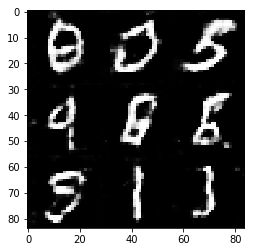

Epoch 1/2... Discriminator Loss: 0.9073... Generator Loss: 1.3614
Epoch 1/2... Discriminator Loss: 1.2868... Generator Loss: 1.8611
Epoch 1/2... Discriminator Loss: 1.0255... Generator Loss: 0.6953
Epoch 1/2... Discriminator Loss: 1.1344... Generator Loss: 0.5591
Epoch 1/2... Discriminator Loss: 1.5364... Generator Loss: 0.3142
Epoch 1/2... Discriminator Loss: 0.9777... Generator Loss: 0.7750
Epoch 1/2... Discriminator Loss: 2.1316... Generator Loss: 0.1406
Epoch 1/2... Discriminator Loss: 1.5142... Generator Loss: 0.3410
Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 0.4123
Epoch 1/2... Discriminator Loss: 1.4595... Generator Loss: 0.3616


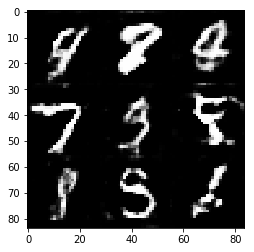

Epoch 1/2... Discriminator Loss: 2.1471... Generator Loss: 0.1494
Epoch 1/2... Discriminator Loss: 1.2316... Generator Loss: 0.4224
Epoch 1/2... Discriminator Loss: 1.4598... Generator Loss: 2.9144
Epoch 1/2... Discriminator Loss: 1.4285... Generator Loss: 0.3956
Epoch 1/2... Discriminator Loss: 1.6909... Generator Loss: 2.6435
Epoch 1/2... Discriminator Loss: 0.9480... Generator Loss: 0.8507
Epoch 1/2... Discriminator Loss: 1.0319... Generator Loss: 0.6498
Epoch 1/2... Discriminator Loss: 0.7491... Generator Loss: 1.1559
Epoch 1/2... Discriminator Loss: 0.9731... Generator Loss: 1.2252
Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 1.9613


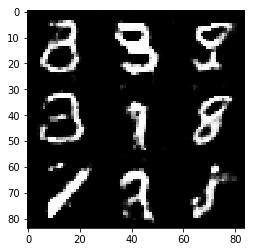

Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 0.4705
Epoch 1/2... Discriminator Loss: 2.1656... Generator Loss: 0.2149
Epoch 1/2... Discriminator Loss: 0.7336... Generator Loss: 1.1667
Epoch 1/2... Discriminator Loss: 1.1958... Generator Loss: 0.5636
Epoch 1/2... Discriminator Loss: 0.9462... Generator Loss: 1.7405
Epoch 1/2... Discriminator Loss: 0.6984... Generator Loss: 2.0479
Epoch 1/2... Discriminator Loss: 1.4089... Generator Loss: 0.3738
Epoch 1/2... Discriminator Loss: 3.0290... Generator Loss: 0.0676
Epoch 1/2... Discriminator Loss: 0.7367... Generator Loss: 1.1513
Epoch 1/2... Discriminator Loss: 0.9957... Generator Loss: 1.3673


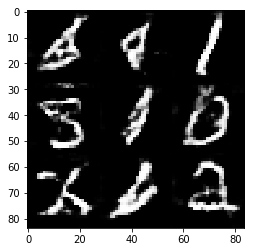

Epoch 1/2... Discriminator Loss: 0.9298... Generator Loss: 0.7737
Epoch 1/2... Discriminator Loss: 0.7088... Generator Loss: 2.2226
Epoch 1/2... Discriminator Loss: 1.5947... Generator Loss: 3.3751
Epoch 1/2... Discriminator Loss: 1.2413... Generator Loss: 1.3520
Epoch 1/2... Discriminator Loss: 1.3162... Generator Loss: 0.4157
Epoch 1/2... Discriminator Loss: 0.8282... Generator Loss: 0.9061
Epoch 1/2... Discriminator Loss: 0.7220... Generator Loss: 1.4214
Epoch 1/2... Discriminator Loss: 1.0541... Generator Loss: 0.7001
Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 0.5601
Epoch 1/2... Discriminator Loss: 0.8741... Generator Loss: 0.8675


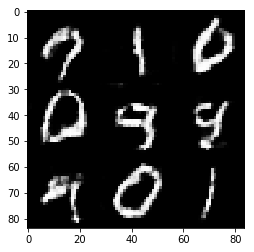

Epoch 1/2... Discriminator Loss: 1.5273... Generator Loss: 0.3192
Epoch 1/2... Discriminator Loss: 1.0790... Generator Loss: 2.0375
Epoch 1/2... Discriminator Loss: 0.6640... Generator Loss: 1.1434
Epoch 1/2... Discriminator Loss: 0.7457... Generator Loss: 1.3899
Epoch 1/2... Discriminator Loss: 0.7281... Generator Loss: 1.0033
Epoch 1/2... Discriminator Loss: 1.1270... Generator Loss: 0.5792
Epoch 1/2... Discriminator Loss: 0.9050... Generator Loss: 2.0007
Epoch 1/2... Discriminator Loss: 0.8951... Generator Loss: 0.9581
Epoch 1/2... Discriminator Loss: 0.6995... Generator Loss: 1.2109
Epoch 1/2... Discriminator Loss: 0.6677... Generator Loss: 1.9363


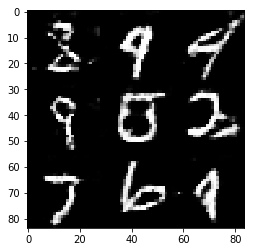

Epoch 1/2... Discriminator Loss: 1.0740... Generator Loss: 1.7800
Epoch 1/2... Discriminator Loss: 0.4784... Generator Loss: 1.6020
Epoch 1/2... Discriminator Loss: 0.8355... Generator Loss: 2.3230
Epoch 1/2... Discriminator Loss: 0.9012... Generator Loss: 1.6485
Epoch 1/2... Discriminator Loss: 0.6397... Generator Loss: 2.2242
Epoch 1/2... Discriminator Loss: 0.4382... Generator Loss: 1.7890
Epoch 1/2... Discriminator Loss: 0.8894... Generator Loss: 1.9679
Epoch 1/2... Discriminator Loss: 1.4551... Generator Loss: 0.3833
Epoch 1/2... Discriminator Loss: 1.0304... Generator Loss: 0.5498
Epoch 1/2... Discriminator Loss: 1.7139... Generator Loss: 0.2379


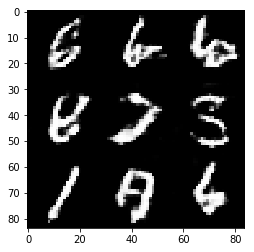

Epoch 1/2... Discriminator Loss: 1.7839... Generator Loss: 0.3040
Epoch 1/2... Discriminator Loss: 0.8878... Generator Loss: 1.0448
Epoch 1/2... Discriminator Loss: 0.9125... Generator Loss: 0.8064
Epoch 1/2... Discriminator Loss: 0.5969... Generator Loss: 0.9838
Epoch 1/2... Discriminator Loss: 0.9679... Generator Loss: 2.4104
Epoch 1/2... Discriminator Loss: 0.5628... Generator Loss: 2.2512
Epoch 1/2... Discriminator Loss: 0.6087... Generator Loss: 0.9793
Epoch 1/2... Discriminator Loss: 0.8372... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 0.6079... Generator Loss: 1.7013
Epoch 1/2... Discriminator Loss: 0.3686... Generator Loss: 2.1076


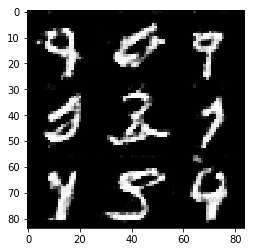

Epoch 1/2... Discriminator Loss: 0.6023... Generator Loss: 1.1325
Epoch 1/2... Discriminator Loss: 1.2036... Generator Loss: 0.5612
Epoch 1/2... Discriminator Loss: 2.7325... Generator Loss: 0.1115
Epoch 1/2... Discriminator Loss: 1.1787... Generator Loss: 0.5279
Epoch 1/2... Discriminator Loss: 2.4471... Generator Loss: 0.1549
Epoch 1/2... Discriminator Loss: 0.7375... Generator Loss: 0.9172
Epoch 1/2... Discriminator Loss: 0.4379... Generator Loss: 1.5952
Epoch 1/2... Discriminator Loss: 0.5137... Generator Loss: 1.7788
Epoch 1/2... Discriminator Loss: 0.4632... Generator Loss: 1.9593
Epoch 1/2... Discriminator Loss: 1.5216... Generator Loss: 0.3266


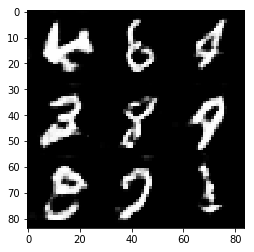

Epoch 1/2... Discriminator Loss: 1.7325... Generator Loss: 0.2921
Epoch 1/2... Discriminator Loss: 1.4542... Generator Loss: 0.3603
Epoch 1/2... Discriminator Loss: 0.9131... Generator Loss: 0.7333
Epoch 1/2... Discriminator Loss: 1.5394... Generator Loss: 0.3382
Epoch 1/2... Discriminator Loss: 0.6399... Generator Loss: 2.1335
Epoch 1/2... Discriminator Loss: 0.3479... Generator Loss: 1.8555
Epoch 1/2... Discriminator Loss: 0.6716... Generator Loss: 1.0272
Epoch 1/2... Discriminator Loss: 0.4956... Generator Loss: 1.3322
Epoch 1/2... Discriminator Loss: 0.6180... Generator Loss: 1.1801
Epoch 1/2... Discriminator Loss: 2.1378... Generator Loss: 0.1977


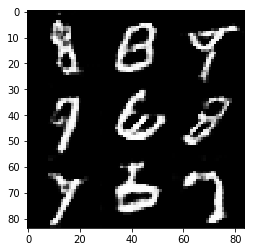

Epoch 1/2... Discriminator Loss: 0.6228... Generator Loss: 1.1837
Epoch 1/2... Discriminator Loss: 0.6164... Generator Loss: 1.5921
Epoch 1/2... Discriminator Loss: 0.8392... Generator Loss: 0.7934
Epoch 1/2... Discriminator Loss: 0.4327... Generator Loss: 1.5729
Epoch 1/2... Discriminator Loss: 0.7617... Generator Loss: 1.7559
Epoch 1/2... Discriminator Loss: 1.3598... Generator Loss: 0.5732
Epoch 1/2... Discriminator Loss: 0.6324... Generator Loss: 1.6153
Epoch 2/2... Discriminator Loss: 0.9244... Generator Loss: 0.7720
Epoch 2/2... Discriminator Loss: 0.4558... Generator Loss: 1.3648
Epoch 2/2... Discriminator Loss: 0.7333... Generator Loss: 0.9691


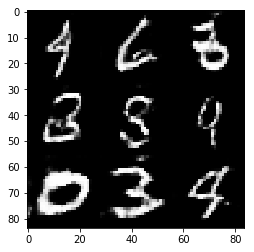

Epoch 2/2... Discriminator Loss: 2.4621... Generator Loss: 0.1489
Epoch 2/2... Discriminator Loss: 0.6275... Generator Loss: 1.0614
Epoch 2/2... Discriminator Loss: 0.2737... Generator Loss: 2.0436
Epoch 2/2... Discriminator Loss: 1.1371... Generator Loss: 0.5500
Epoch 2/2... Discriminator Loss: 0.9975... Generator Loss: 0.6066
Epoch 2/2... Discriminator Loss: 0.5724... Generator Loss: 1.3370
Epoch 2/2... Discriminator Loss: 0.7286... Generator Loss: 2.9761
Epoch 2/2... Discriminator Loss: 1.1515... Generator Loss: 2.6463
Epoch 2/2... Discriminator Loss: 0.6472... Generator Loss: 1.0552
Epoch 2/2... Discriminator Loss: 0.6604... Generator Loss: 1.0008


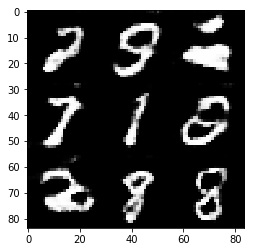

Epoch 2/2... Discriminator Loss: 1.4390... Generator Loss: 4.5680
Epoch 2/2... Discriminator Loss: 0.5446... Generator Loss: 1.2256
Epoch 2/2... Discriminator Loss: 0.7747... Generator Loss: 1.2910
Epoch 2/2... Discriminator Loss: 1.2435... Generator Loss: 0.5992
Epoch 2/2... Discriminator Loss: 0.4909... Generator Loss: 2.2029
Epoch 2/2... Discriminator Loss: 0.6563... Generator Loss: 1.0335
Epoch 2/2... Discriminator Loss: 0.4240... Generator Loss: 1.8884
Epoch 2/2... Discriminator Loss: 1.1049... Generator Loss: 0.6110
Epoch 2/2... Discriminator Loss: 0.7187... Generator Loss: 0.9538
Epoch 2/2... Discriminator Loss: 0.3821... Generator Loss: 1.5917


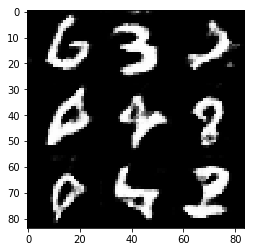

Epoch 2/2... Discriminator Loss: 0.8311... Generator Loss: 0.9345
Epoch 2/2... Discriminator Loss: 1.0408... Generator Loss: 2.6287
Epoch 2/2... Discriminator Loss: 0.9115... Generator Loss: 1.1092
Epoch 2/2... Discriminator Loss: 0.6091... Generator Loss: 1.9435
Epoch 2/2... Discriminator Loss: 0.5997... Generator Loss: 1.4214
Epoch 2/2... Discriminator Loss: 2.2619... Generator Loss: 0.2360
Epoch 2/2... Discriminator Loss: 0.7786... Generator Loss: 0.8103
Epoch 2/2... Discriminator Loss: 0.2005... Generator Loss: 2.1075
Epoch 2/2... Discriminator Loss: 0.5744... Generator Loss: 1.3966
Epoch 2/2... Discriminator Loss: 0.5600... Generator Loss: 1.5170


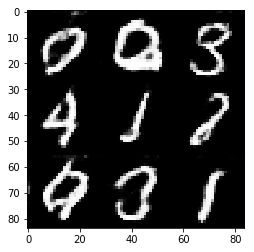

Epoch 2/2... Discriminator Loss: 0.3538... Generator Loss: 2.2560
Epoch 2/2... Discriminator Loss: 2.8369... Generator Loss: 4.8798
Epoch 2/2... Discriminator Loss: 0.5896... Generator Loss: 2.1357
Epoch 2/2... Discriminator Loss: 0.7105... Generator Loss: 0.8153
Epoch 2/2... Discriminator Loss: 0.9971... Generator Loss: 0.7839
Epoch 2/2... Discriminator Loss: 2.2048... Generator Loss: 0.1897
Epoch 2/2... Discriminator Loss: 0.8037... Generator Loss: 2.4837
Epoch 2/2... Discriminator Loss: 0.5483... Generator Loss: 1.1051
Epoch 2/2... Discriminator Loss: 1.4998... Generator Loss: 0.3487
Epoch 2/2... Discriminator Loss: 0.4842... Generator Loss: 1.9411


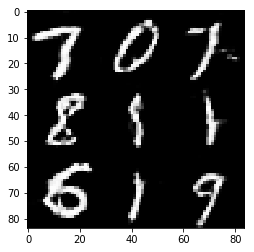

Epoch 2/2... Discriminator Loss: 0.5978... Generator Loss: 1.4119
Epoch 2/2... Discriminator Loss: 0.7591... Generator Loss: 0.8749
Epoch 2/2... Discriminator Loss: 0.3308... Generator Loss: 1.6131
Epoch 2/2... Discriminator Loss: 0.9651... Generator Loss: 1.9180
Epoch 2/2... Discriminator Loss: 0.7961... Generator Loss: 0.9625
Epoch 2/2... Discriminator Loss: 1.3795... Generator Loss: 4.9264
Epoch 2/2... Discriminator Loss: 1.3649... Generator Loss: 0.4852
Epoch 2/2... Discriminator Loss: 0.3860... Generator Loss: 1.5102
Epoch 2/2... Discriminator Loss: 0.4981... Generator Loss: 1.1836
Epoch 2/2... Discriminator Loss: 0.3329... Generator Loss: 1.8702


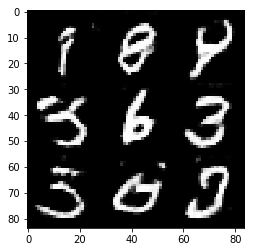

Epoch 2/2... Discriminator Loss: 0.6361... Generator Loss: 1.0495
Epoch 2/2... Discriminator Loss: 0.4587... Generator Loss: 1.3365
Epoch 2/2... Discriminator Loss: 4.4407... Generator Loss: 8.0854
Epoch 2/2... Discriminator Loss: 0.4638... Generator Loss: 1.3718
Epoch 2/2... Discriminator Loss: 0.4706... Generator Loss: 2.1954
Epoch 2/2... Discriminator Loss: 1.6406... Generator Loss: 0.3078
Epoch 2/2... Discriminator Loss: 0.7698... Generator Loss: 1.0763
Epoch 2/2... Discriminator Loss: 0.5768... Generator Loss: 1.1664
Epoch 2/2... Discriminator Loss: 1.2827... Generator Loss: 0.5260
Epoch 2/2... Discriminator Loss: 1.0181... Generator Loss: 0.5793


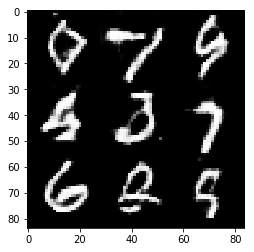

Epoch 2/2... Discriminator Loss: 0.5660... Generator Loss: 1.1636
Epoch 2/2... Discriminator Loss: 0.4822... Generator Loss: 1.7908
Epoch 2/2... Discriminator Loss: 1.3435... Generator Loss: 0.4629
Epoch 2/2... Discriminator Loss: 1.6395... Generator Loss: 0.3594
Epoch 2/2... Discriminator Loss: 0.6479... Generator Loss: 1.1377
Epoch 2/2... Discriminator Loss: 0.4810... Generator Loss: 1.3787
Epoch 2/2... Discriminator Loss: 1.4756... Generator Loss: 0.4103
Epoch 2/2... Discriminator Loss: 0.4586... Generator Loss: 2.0244
Epoch 2/2... Discriminator Loss: 1.3061... Generator Loss: 0.4723
Epoch 2/2... Discriminator Loss: 1.4125... Generator Loss: 0.3900


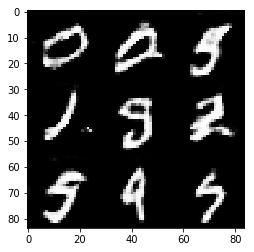

Epoch 2/2... Discriminator Loss: 1.0594... Generator Loss: 0.5773
Epoch 2/2... Discriminator Loss: 0.5584... Generator Loss: 1.2653
Epoch 2/2... Discriminator Loss: 0.5990... Generator Loss: 1.0627
Epoch 2/2... Discriminator Loss: 0.5662... Generator Loss: 1.0945
Epoch 2/2... Discriminator Loss: 0.3816... Generator Loss: 2.0859
Epoch 2/2... Discriminator Loss: 0.6549... Generator Loss: 1.0047
Epoch 2/2... Discriminator Loss: 0.7427... Generator Loss: 1.0140
Epoch 2/2... Discriminator Loss: 0.3379... Generator Loss: 1.9549
Epoch 2/2... Discriminator Loss: 0.4640... Generator Loss: 1.3081
Epoch 2/2... Discriminator Loss: 0.8383... Generator Loss: 0.8602


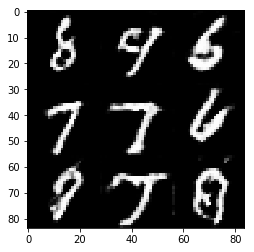

Epoch 2/2... Discriminator Loss: 0.3750... Generator Loss: 1.7326
Epoch 2/2... Discriminator Loss: 0.8454... Generator Loss: 3.1722
Epoch 2/2... Discriminator Loss: 0.7906... Generator Loss: 2.9619
Epoch 2/2... Discriminator Loss: 0.6204... Generator Loss: 2.3641
Epoch 2/2... Discriminator Loss: 1.8764... Generator Loss: 0.4266
Epoch 2/2... Discriminator Loss: 0.6943... Generator Loss: 1.0104
Epoch 2/2... Discriminator Loss: 1.1177... Generator Loss: 0.6817
Epoch 2/2... Discriminator Loss: 0.6744... Generator Loss: 1.0537
Epoch 2/2... Discriminator Loss: 1.1001... Generator Loss: 0.8601
Epoch 2/2... Discriminator Loss: 0.6575... Generator Loss: 1.2430


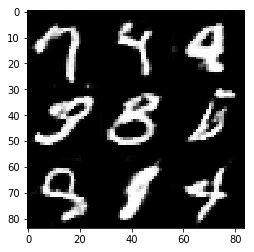

Epoch 2/2... Discriminator Loss: 0.3087... Generator Loss: 1.7533
Epoch 2/2... Discriminator Loss: 1.0798... Generator Loss: 0.7476
Epoch 2/2... Discriminator Loss: 0.5066... Generator Loss: 1.3098
Epoch 2/2... Discriminator Loss: 3.3474... Generator Loss: 0.0713
Epoch 2/2... Discriminator Loss: 0.6793... Generator Loss: 0.9610
Epoch 2/2... Discriminator Loss: 0.3577... Generator Loss: 1.6243
Epoch 2/2... Discriminator Loss: 0.3410... Generator Loss: 1.8046
Epoch 2/2... Discriminator Loss: 0.3483... Generator Loss: 1.6659
Epoch 2/2... Discriminator Loss: 0.5024... Generator Loss: 1.4257
Epoch 2/2... Discriminator Loss: 0.7549... Generator Loss: 0.9301


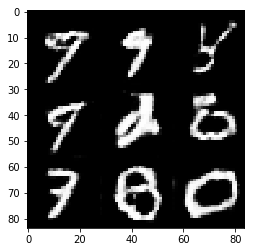

Epoch 2/2... Discriminator Loss: 0.4867... Generator Loss: 1.3509
Epoch 2/2... Discriminator Loss: 1.2019... Generator Loss: 0.6327
Epoch 2/2... Discriminator Loss: 0.8608... Generator Loss: 1.0300
Epoch 2/2... Discriminator Loss: 0.6790... Generator Loss: 1.1100
Epoch 2/2... Discriminator Loss: 0.5044... Generator Loss: 1.2509
Epoch 2/2... Discriminator Loss: 0.6488... Generator Loss: 1.0539
Epoch 2/2... Discriminator Loss: 0.3060... Generator Loss: 2.3212
Epoch 2/2... Discriminator Loss: 1.0926... Generator Loss: 3.0767
Epoch 2/2... Discriminator Loss: 2.0024... Generator Loss: 5.1000
Epoch 2/2... Discriminator Loss: 1.2527... Generator Loss: 0.4838


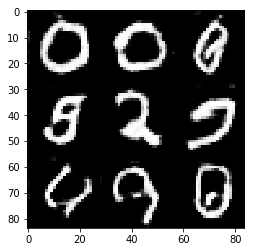

Epoch 2/2... Discriminator Loss: 0.5826... Generator Loss: 1.3634
Epoch 2/2... Discriminator Loss: 1.2006... Generator Loss: 0.5605
Epoch 2/2... Discriminator Loss: 0.8197... Generator Loss: 0.9679
Epoch 2/2... Discriminator Loss: 0.5823... Generator Loss: 1.0712
Epoch 2/2... Discriminator Loss: 2.0231... Generator Loss: 0.3475
Epoch 2/2... Discriminator Loss: 0.4233... Generator Loss: 2.2042
Epoch 2/2... Discriminator Loss: 1.2257... Generator Loss: 0.5862
Epoch 2/2... Discriminator Loss: 0.4730... Generator Loss: 1.4155
Epoch 2/2... Discriminator Loss: 0.4824... Generator Loss: 1.8229
Epoch 2/2... Discriminator Loss: 0.4124... Generator Loss: 1.4916


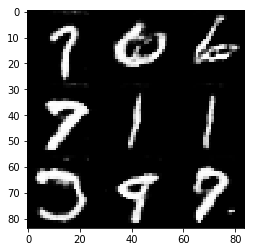

Epoch 2/2... Discriminator Loss: 1.4271... Generator Loss: 0.4380
Epoch 2/2... Discriminator Loss: 0.2872... Generator Loss: 2.8166
Epoch 2/2... Discriminator Loss: 0.5516... Generator Loss: 1.1273
Epoch 2/2... Discriminator Loss: 0.4546... Generator Loss: 1.5123
Epoch 2/2... Discriminator Loss: 0.9480... Generator Loss: 0.8113
Epoch 2/2... Discriminator Loss: 0.4027... Generator Loss: 2.5999
Epoch 2/2... Discriminator Loss: 0.4594... Generator Loss: 1.3445
Epoch 2/2... Discriminator Loss: 0.8591... Generator Loss: 3.1852
Epoch 2/2... Discriminator Loss: 0.8254... Generator Loss: 0.7497
Epoch 2/2... Discriminator Loss: 0.6180... Generator Loss: 1.2724


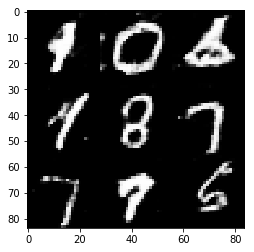

Epoch 2/2... Discriminator Loss: 0.2644... Generator Loss: 2.5666
Epoch 2/2... Discriminator Loss: 0.1710... Generator Loss: 3.4070
Epoch 2/2... Discriminator Loss: 0.5850... Generator Loss: 1.1677
Epoch 2/2... Discriminator Loss: 0.3922... Generator Loss: 1.9478
Epoch 2/2... Discriminator Loss: 1.0291... Generator Loss: 0.7412
Epoch 2/2... Discriminator Loss: 0.7947... Generator Loss: 1.4108
Epoch 2/2... Discriminator Loss: 0.4971... Generator Loss: 1.3499
Epoch 2/2... Discriminator Loss: 0.5573... Generator Loss: 2.7716
Epoch 2/2... Discriminator Loss: 0.5156... Generator Loss: 2.4131
Epoch 2/2... Discriminator Loss: 3.2570... Generator Loss: 0.1229


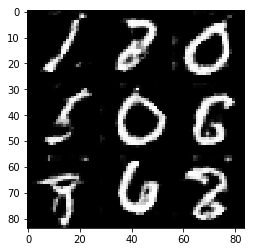

Epoch 2/2... Discriminator Loss: 0.4647... Generator Loss: 2.7845
Epoch 2/2... Discriminator Loss: 0.6721... Generator Loss: 0.9661
Epoch 2/2... Discriminator Loss: 0.8668... Generator Loss: 0.9066
Epoch 2/2... Discriminator Loss: 0.8562... Generator Loss: 1.0277
Epoch 2/2... Discriminator Loss: 0.4111... Generator Loss: 1.5762
Epoch 2/2... Discriminator Loss: 1.8333... Generator Loss: 5.5554
Epoch 2/2... Discriminator Loss: 0.8686... Generator Loss: 0.7947
Epoch 2/2... Discriminator Loss: 0.3065... Generator Loss: 1.8056
Epoch 2/2... Discriminator Loss: 1.0147... Generator Loss: 4.5455
Epoch 2/2... Discriminator Loss: 0.3603... Generator Loss: 1.7203


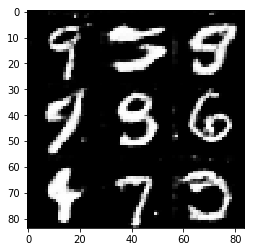

Epoch 2/2... Discriminator Loss: 0.4966... Generator Loss: 1.3625
Epoch 2/2... Discriminator Loss: 0.9278... Generator Loss: 0.7642
Epoch 2/2... Discriminator Loss: 0.5758... Generator Loss: 1.2688
Epoch 2/2... Discriminator Loss: 1.1236... Generator Loss: 0.7573
Epoch 2/2... Discriminator Loss: 0.7005... Generator Loss: 1.0239
Epoch 2/2... Discriminator Loss: 0.4193... Generator Loss: 3.8828
Epoch 2/2... Discriminator Loss: 0.5309... Generator Loss: 1.2237
Epoch 2/2... Discriminator Loss: 0.6677... Generator Loss: 1.1683
Epoch 2/2... Discriminator Loss: 4.2105... Generator Loss: 0.0453
Epoch 2/2... Discriminator Loss: 0.8099... Generator Loss: 1.2390


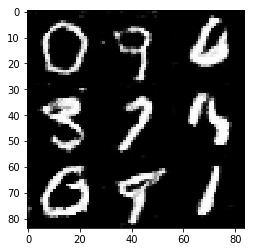

Epoch 2/2... Discriminator Loss: 2.1320... Generator Loss: 0.2618
Epoch 2/2... Discriminator Loss: 1.0936... Generator Loss: 3.9461
Epoch 2/2... Discriminator Loss: 0.6416... Generator Loss: 1.0438
Epoch 2/2... Discriminator Loss: 0.5209... Generator Loss: 1.4157
Epoch 2/2... Discriminator Loss: 0.2485... Generator Loss: 1.9429
Epoch 2/2... Discriminator Loss: 0.4707... Generator Loss: 3.9415
Epoch 2/2... Discriminator Loss: 0.6493... Generator Loss: 1.1850
Epoch 2/2... Discriminator Loss: 0.2232... Generator Loss: 2.3579
Epoch 2/2... Discriminator Loss: 4.3315... Generator Loss: 0.0674
Epoch 2/2... Discriminator Loss: 0.3087... Generator Loss: 2.2807


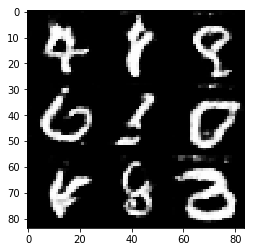

Epoch 2/2... Discriminator Loss: 0.5457... Generator Loss: 2.1904
Epoch 2/2... Discriminator Loss: 0.4824... Generator Loss: 1.4042
Epoch 2/2... Discriminator Loss: 0.6487... Generator Loss: 1.1790
Epoch 2/2... Discriminator Loss: 1.3127... Generator Loss: 0.5340
Epoch 2/2... Discriminator Loss: 0.5797... Generator Loss: 1.2591
Epoch 2/2... Discriminator Loss: 0.6579... Generator Loss: 1.1812
Epoch 2/2... Discriminator Loss: 1.5388... Generator Loss: 0.3233
Epoch 2/2... Discriminator Loss: 2.3858... Generator Loss: 5.1022
Epoch 2/2... Discriminator Loss: 1.9064... Generator Loss: 4.6327
Epoch 2/2... Discriminator Loss: 0.4581... Generator Loss: 1.6283


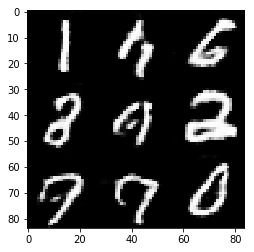

Epoch 2/2... Discriminator Loss: 0.3443... Generator Loss: 1.7528
Epoch 2/2... Discriminator Loss: 1.6896... Generator Loss: 6.7787
Epoch 2/2... Discriminator Loss: 0.2227... Generator Loss: 2.1952
Epoch 2/2... Discriminator Loss: 0.7435... Generator Loss: 0.9497
Epoch 2/2... Discriminator Loss: 0.2064... Generator Loss: 2.2001


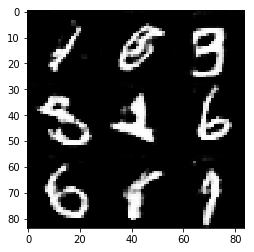

In [12]:
batch_size = 32
z_dim = 126
learning_rate = 0.0009
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

3
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 9.2648
Epoch 1/1... Discriminator Loss: 1.6540... Generator Loss: 0.3649
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 7.0729
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.8868... Generator Loss: 0.2848
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 3.1699
Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 2.4803
Epoch 1/1... Discriminator Loss: 3.5182... Generator Loss: 0.0358
Epoch 1/1... Discriminator Loss: 1.5656... Generator Loss: 1.5617
Epoch 1/1... Discriminator Loss: 0.4243... Generator Loss: 2.3329


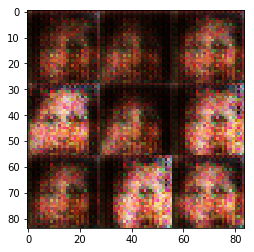

Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 1.1434
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 2.5825... Generator Loss: 0.1130
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 1.2951
Epoch 1/1... Discriminator Loss: 1.7280... Generator Loss: 0.3726
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 1.9926
Epoch 1/1... Discriminator Loss: 1.9013... Generator Loss: 1.6754


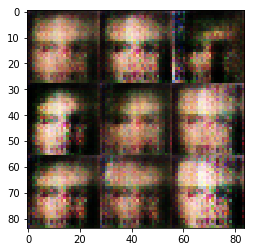

Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.5561... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.8152... Generator Loss: 0.5180
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.5404
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.9687... Generator Loss: 0.2279
Epoch 1/1... Discriminator Loss: 1.6714... Generator Loss: 1.7050


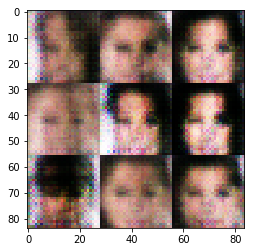

Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 2.2069... Generator Loss: 0.1508
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.8284... Generator Loss: 0.3278
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 1.3468
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.9623... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 1.0478


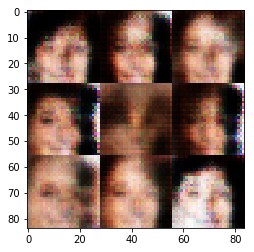

Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.4313
Epoch 1/1... Discriminator Loss: 2.9075... Generator Loss: 0.0798
Epoch 1/1... Discriminator Loss: 1.6254... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.4376
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 1.9111
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 0.9232


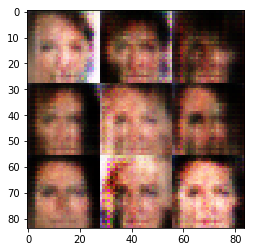

Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.4776
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.4446
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.3422
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.4529
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.7955... Generator Loss: 0.2329
Epoch 1/1... Discriminator Loss: 1.6233... Generator Loss: 1.8689


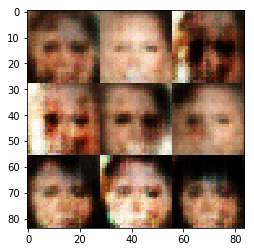

Epoch 1/1... Discriminator Loss: 1.7773... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.5049
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 1.4794
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.5495
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 2.4506... Generator Loss: 0.1255
Epoch 1/1... Discriminator Loss: 1.0834... Generator Loss: 0.8763


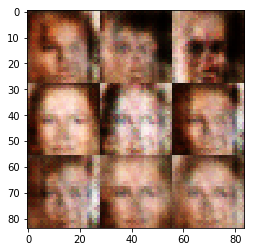

Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.3382
Epoch 1/1... Discriminator Loss: 1.7595... Generator Loss: 0.2922
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.5508
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.5379


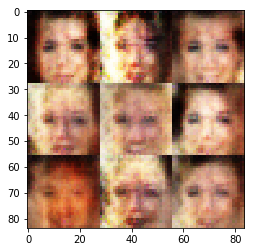

Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.4118
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.4990
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.0849
Epoch 1/1... Discriminator Loss: 1.8032... Generator Loss: 0.2462
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.8235... Generator Loss: 2.3640
Epoch 1/1... Discriminator Loss: 1.6411... Generator Loss: 1.9019
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.4987
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.8622


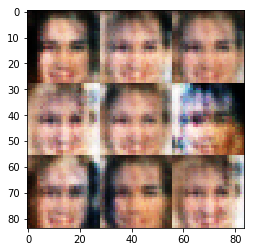

Epoch 1/1... Discriminator Loss: 1.6881... Generator Loss: 1.6197
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 1.5667
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 1.1099
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.0397... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 1.1818


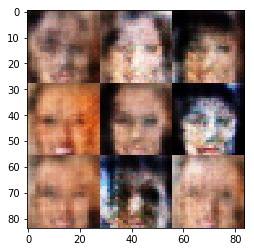

Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.4424
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 1.0258
Epoch 1/1... Discriminator Loss: 1.7420... Generator Loss: 1.9804
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.4916
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.4250
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.4949
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.3534


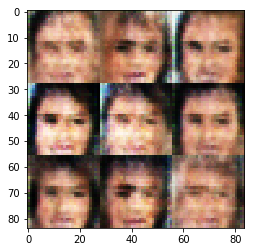

Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 1.5376
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.5370... Generator Loss: 0.5512
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.6359... Generator Loss: 0.4004
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 1.3314
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 1.9692... Generator Loss: 1.6885


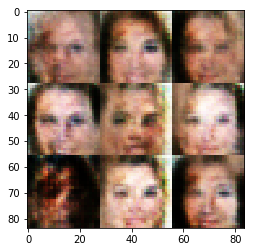

Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 1.6318
Epoch 1/1... Discriminator Loss: 1.7810... Generator Loss: 2.3040
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 1.6615
Epoch 1/1... Discriminator Loss: 0.9685... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.5705... Generator Loss: 0.2520


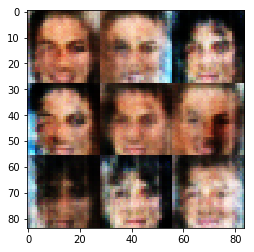

Epoch 1/1... Discriminator Loss: 1.9291... Generator Loss: 0.1880
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.2254
Epoch 1/1... Discriminator Loss: 2.1976... Generator Loss: 0.1390
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 1.2365
Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 1.4880


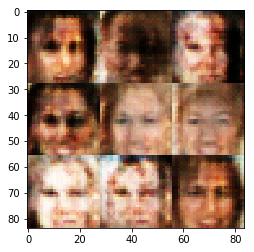

Epoch 1/1... Discriminator Loss: 1.5712... Generator Loss: 0.2827
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.5112
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.3592
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 1.3764
Epoch 1/1... Discriminator Loss: 1.6668... Generator Loss: 0.2993
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 1.5907


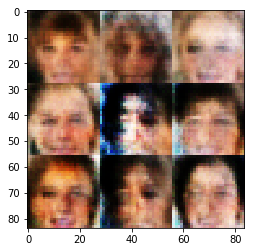

Epoch 1/1... Discriminator Loss: 1.6700... Generator Loss: 0.3174
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.3626
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.3327
Epoch 1/1... Discriminator Loss: 0.8994... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.6279... Generator Loss: 0.5158
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 0.9587


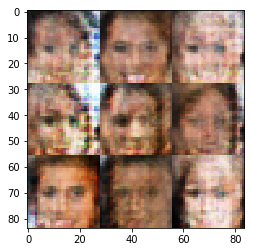

Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 2.4757... Generator Loss: 0.1029
Epoch 1/1... Discriminator Loss: 0.8087... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 1.6423... Generator Loss: 0.3124
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 0.3320
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.7234


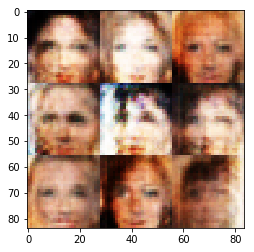

Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 1.9035
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.5442
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 1.2759
Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.4622
Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.4636
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.3857


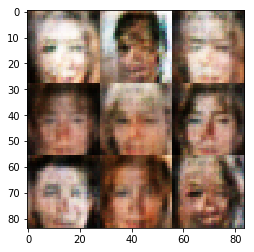

Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 1.8141
Epoch 1/1... Discriminator Loss: 1.5743... Generator Loss: 0.4160
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 1.1286
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 2.1511... Generator Loss: 0.1591
Epoch 1/1... Discriminator Loss: 1.5630... Generator Loss: 0.3194
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.4587
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.5862... Generator Loss: 0.3063
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.9662


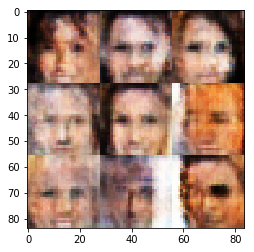

Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 1.1257
Epoch 1/1... Discriminator Loss: 1.8001... Generator Loss: 0.2273
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 1.1176
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.4268
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.4133
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.4852
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.6390... Generator Loss: 0.2969


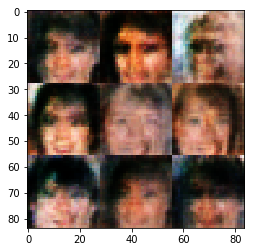

Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 1.3910
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 0.3692
Epoch 1/1... Discriminator Loss: 1.0363... Generator Loss: 1.1789
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 1.2475
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.4880
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 1.3502


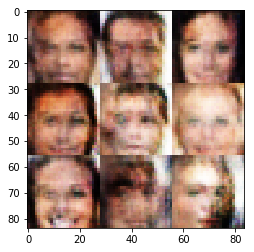

Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.4594
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.5421
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 0.8801


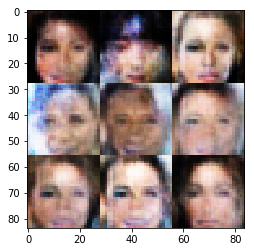

Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.4893
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.4814
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.5970... Generator Loss: 0.4202
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 1.9236
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.8898


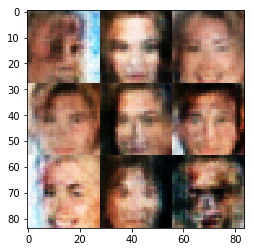

Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.3279
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.5455... Generator Loss: 1.8410
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 0.9537
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.4318
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 1.0829
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 0.9145


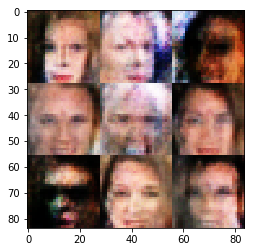

Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.3859
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.5052
Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 1.1980
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 0.8651... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.4116


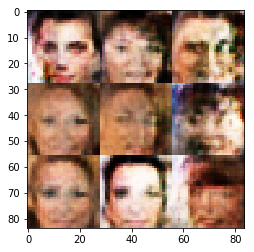

Epoch 1/1... Discriminator Loss: 1.6842... Generator Loss: 1.3992
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.4885
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.5270
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.5871
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.3871


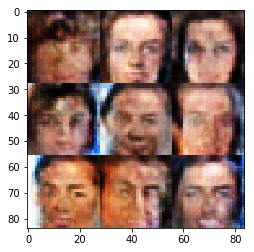

Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 1.7664... Generator Loss: 0.3591
Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 1.0119
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.4811
Epoch 1/1... Discriminator Loss: 1.8922... Generator Loss: 0.2021
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 0.9553
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 0.9857


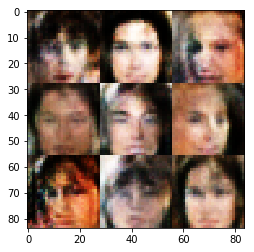

Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 1.1491
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.5594... Generator Loss: 0.2931
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.5822
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 0.6027... Generator Loss: 1.2022
Epoch 1/1... Discriminator Loss: 1.6539... Generator Loss: 1.2330
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 1.6675


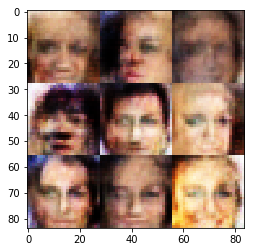

Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.4976
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 0.7301... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.5439
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 1.1376


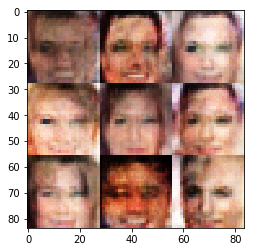

Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.4237
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 1.6476
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 1.0799
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 1.0106
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.4129


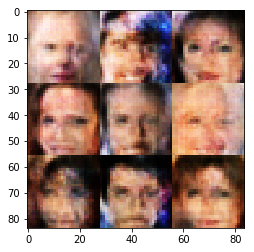

Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.4436
Epoch 1/1... Discriminator Loss: 2.6063... Generator Loss: 0.1207
Epoch 1/1... Discriminator Loss: 1.7310... Generator Loss: 0.2998
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.4536
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.4757


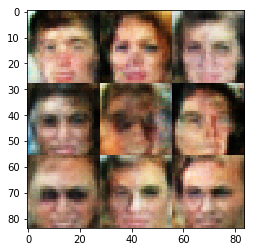

Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.4494
Epoch 1/1... Discriminator Loss: 1.7642... Generator Loss: 0.2321
Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 2.0038... Generator Loss: 0.2052
Epoch 1/1... Discriminator Loss: 1.7172... Generator Loss: 0.3369
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.9698


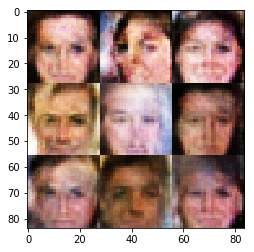

Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.3225
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.6180... Generator Loss: 1.7589
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.5094
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 1.3636
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.4322
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.3744
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 1.0691
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.5332


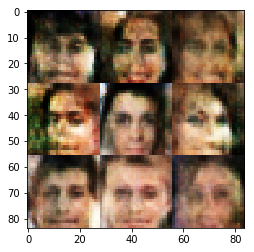

Epoch 1/1... Discriminator Loss: 2.7666... Generator Loss: 0.0828
Epoch 1/1... Discriminator Loss: 2.1174... Generator Loss: 2.1071
Epoch 1/1... Discriminator Loss: 0.8003... Generator Loss: 1.2922
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.5024
Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 1.0054
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.8021... Generator Loss: 2.0591
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 2.0550... Generator Loss: 0.2076
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.8585


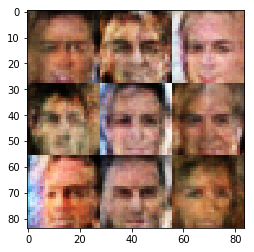

Epoch 1/1... Discriminator Loss: 0.7026... Generator Loss: 1.1929
Epoch 1/1... Discriminator Loss: 1.6861... Generator Loss: 0.3726
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 0.5409... Generator Loss: 1.6080
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.3039
Epoch 1/1... Discriminator Loss: 0.8172... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.4406
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 2.5530


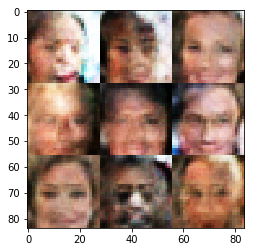

Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 1.8455... Generator Loss: 0.2216
Epoch 1/1... Discriminator Loss: 1.5807... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.6243... Generator Loss: 0.2905
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.5480
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.3645


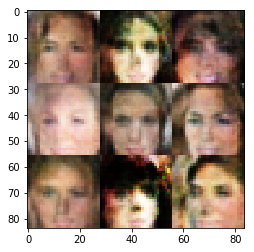

Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.3960
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.4997
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.4236
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.3544
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.4576
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 1.3364
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 1.9047


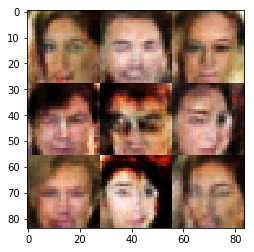

Epoch 1/1... Discriminator Loss: 2.0100... Generator Loss: 0.1833
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.5074
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 1.4284
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.4508
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.5145
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.0517


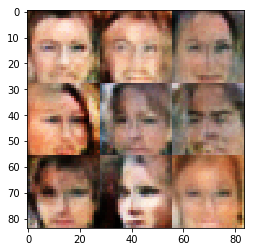

Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 1.2780
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 0.5545... Generator Loss: 1.0087
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 2.6439
Epoch 1/1... Discriminator Loss: 1.6547... Generator Loss: 0.2973
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.4855
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.8909... Generator Loss: 0.2114


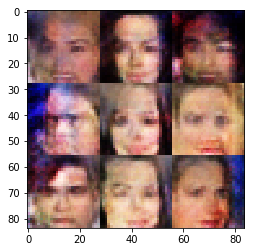

Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.4619
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.5657
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.4945
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.4696
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 1.2291
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.5245


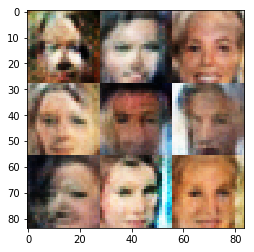

Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.6745... Generator Loss: 0.2664
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 1.1598
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.3418
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 1.0314
Epoch 1/1... Discriminator Loss: 0.7649... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.4107


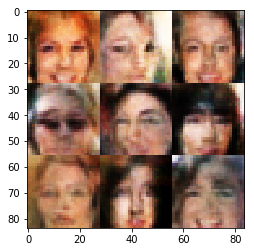

Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.2796
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.8277


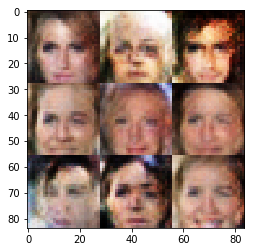

Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.7139... Generator Loss: 0.2893
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.4589
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.5670
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.4691
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.4750
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 0.5851


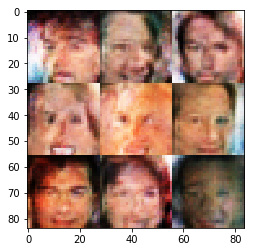

Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.6947... Generator Loss: 2.4709
Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 0.3181
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.4839
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.4274
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.7486


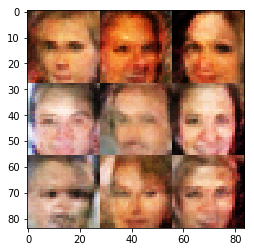

Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.5218
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 1.2543
Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.4823
Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 1.3554
Epoch 1/1... Discriminator Loss: 0.8916... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.9644
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.5901


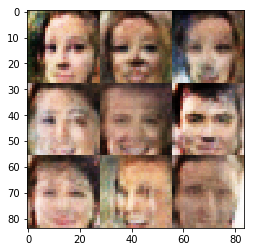

Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.4307
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.5108
Epoch 1/1... Discriminator Loss: 1.8622... Generator Loss: 0.2540
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 1.2554
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.2836
Epoch 1/1... Discriminator Loss: 0.6392... Generator Loss: 0.9476


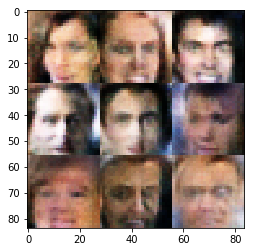

Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.3940
Epoch 1/1... Discriminator Loss: 0.9006... Generator Loss: 1.0103
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.5511
Epoch 1/1... Discriminator Loss: 1.6195... Generator Loss: 0.3180
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 1.0668
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 0.6011


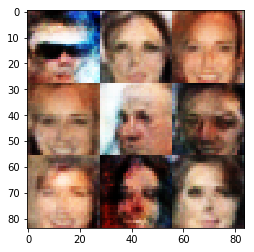

Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.4165
Epoch 1/1... Discriminator Loss: 0.8934... Generator Loss: 1.3311
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.3729
Epoch 1/1... Discriminator Loss: 1.5954... Generator Loss: 0.3265
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.4201
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.4164
Epoch 1/1... Discriminator Loss: 1.5922... Generator Loss: 0.3230


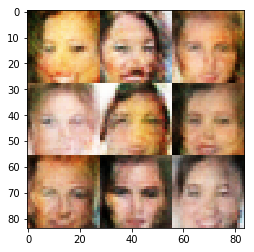

Epoch 1/1... Discriminator Loss: 1.8111... Generator Loss: 0.2179
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.4587
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.4767
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.7181


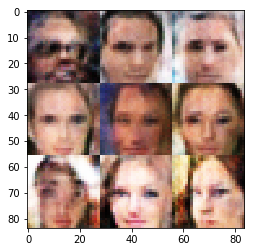

Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.3256
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 0.5551... Generator Loss: 1.0518
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 0.8933... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.3807
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.2971
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 0.5577
Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 1.8991


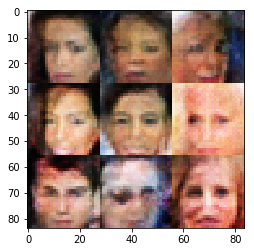

Epoch 1/1... Discriminator Loss: 1.6754... Generator Loss: 0.2482
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 0.6097... Generator Loss: 1.9508
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.4681
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.5127
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.4798
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.5608


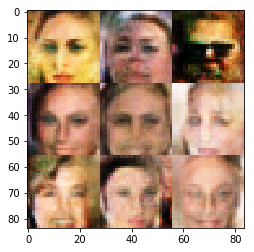

Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.4079
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.5322
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.4141
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7444


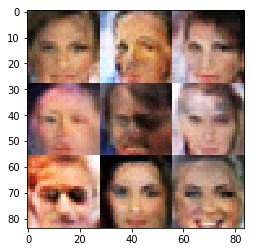

Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 1.4116
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 1.8089
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.5111
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 1.2320
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.5336
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.5836
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 1.3104


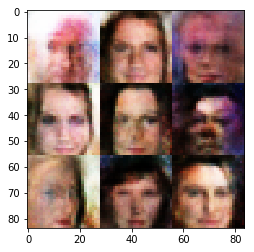

Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.4204
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.3923
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.6921... Generator Loss: 0.2283
Epoch 1/1... Discriminator Loss: 0.7205... Generator Loss: 1.3908
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.3379
Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 1.0412
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.4572
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 0.8415


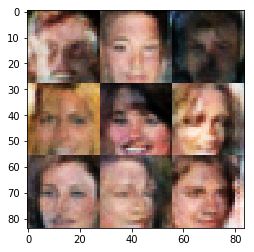

Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 1.5460
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 1.2619
Epoch 1/1... Discriminator Loss: 1.6491... Generator Loss: 1.2995
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.3030
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 1.4453
Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 1.1556
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.5012
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.5180


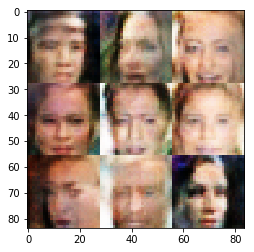

Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.4258
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.4393
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.3445
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.4779
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.4266
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.7671


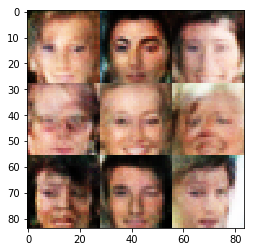

Epoch 1/1... Discriminator Loss: 1.8506... Generator Loss: 0.1996
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.3994
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 1.0345
Epoch 1/1... Discriminator Loss: 1.9856... Generator Loss: 0.2481
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.7802


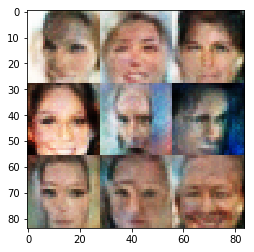

Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 1.0418
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.4520
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.4149
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 0.7043


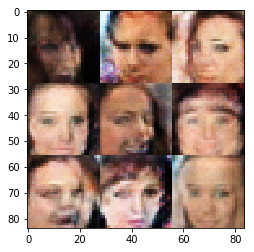

Epoch 1/1... Discriminator Loss: 0.8364... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.3698
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 0.7817... Generator Loss: 0.9370


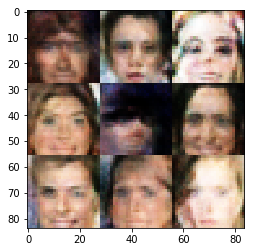

Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 1.2946
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.4665
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.3576
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 0.8177... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 0.7754... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.5672


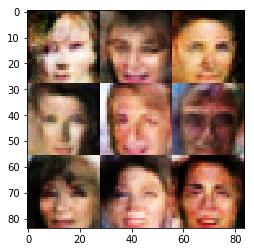

Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 1.0345
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.4940
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 0.7059


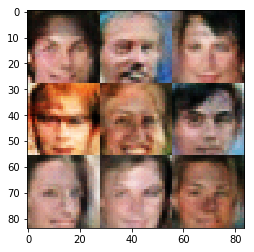

Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 0.9532
Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.5517
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.3263
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 1.0679
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 1.0374


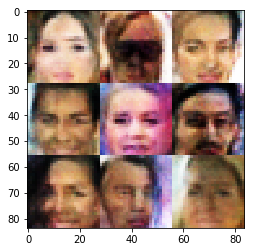

Epoch 1/1... Discriminator Loss: 0.7793... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.4896
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.4610
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 1.1255
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.4682
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.0305
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.4095


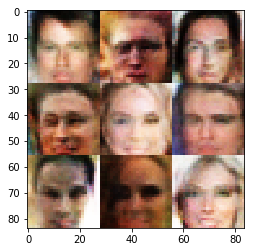

Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.4279
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 0.8963... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 1.6684... Generator Loss: 0.2777
Epoch 1/1... Discriminator Loss: 1.7151... Generator Loss: 0.2695
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.5915... Generator Loss: 0.2660
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 0.5513
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.4601


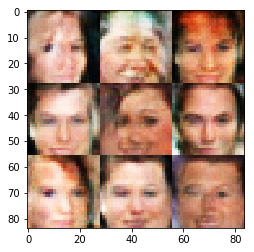

Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 1.2617
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.4537
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.4756
Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.6705


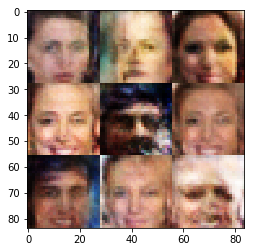

Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 1.6990... Generator Loss: 0.2675
Epoch 1/1... Discriminator Loss: 1.6345... Generator Loss: 0.2685
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 1.5530... Generator Loss: 0.3005
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 2.6158
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.8975


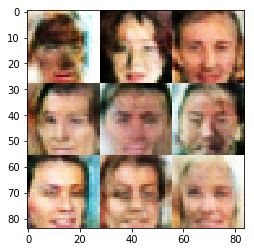

Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 1.2551
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.4101
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.3148
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.4085
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 1.4004
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.9457... Generator Loss: 0.1850
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 1.3180


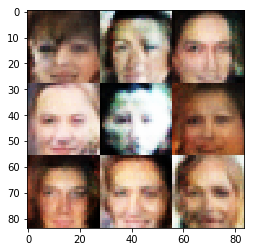

Epoch 1/1... Discriminator Loss: 0.3430... Generator Loss: 1.9030
Epoch 1/1... Discriminator Loss: 0.5660... Generator Loss: 1.3973
Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 2.6257
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.3939
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.3995
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.3282


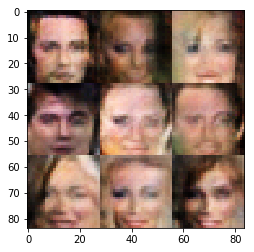

Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 1.0074
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 2.0830
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 1.2663
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.4885
Epoch 1/1... Discriminator Loss: 1.8708... Generator Loss: 0.2129
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.4660
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.3473
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.5416
Epoch 1/1... Discriminator Loss: 2.1583... Generator Loss: 1.0667


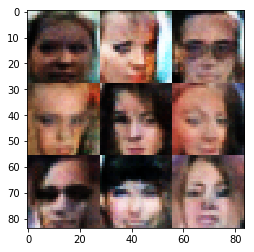

Epoch 1/1... Discriminator Loss: 0.3185... Generator Loss: 2.1203
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 0.8578... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.5032
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.4756
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.5357
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.5517
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.7071


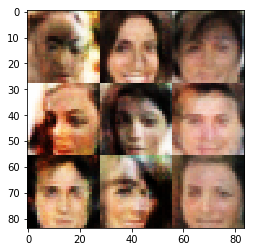

Epoch 1/1... Discriminator Loss: 1.5194... Generator Loss: 0.2936
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.4285
Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.7112


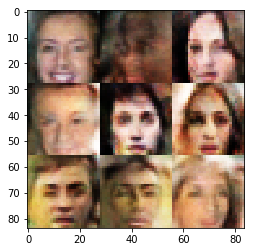

Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 1.4129
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.4374
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.5487
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.4059


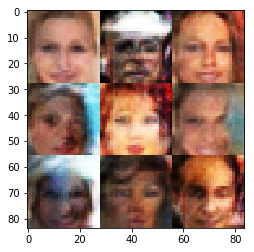

Epoch 1/1... Discriminator Loss: 0.6008... Generator Loss: 1.0583
Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 1.2525
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 2.4539
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.5031
Epoch 1/1... Discriminator Loss: 1.7823... Generator Loss: 0.2430
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.4275
Epoch 1/1... Discriminator Loss: 0.9273... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 0.6121... Generator Loss: 2.5368


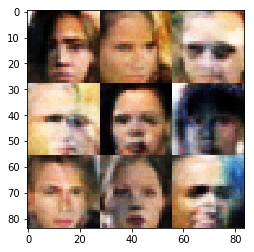

Epoch 1/1... Discriminator Loss: 0.6844... Generator Loss: 1.3690
Epoch 1/1... Discriminator Loss: 0.6961... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 0.4057... Generator Loss: 1.8135
Epoch 1/1... Discriminator Loss: 0.8714... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 2.0678... Generator Loss: 0.1664
Epoch 1/1... Discriminator Loss: 1.7972... Generator Loss: 0.2441
Epoch 1/1... Discriminator Loss: 0.3489... Generator Loss: 2.2468
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 0.4171... Generator Loss: 2.2422
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.4227


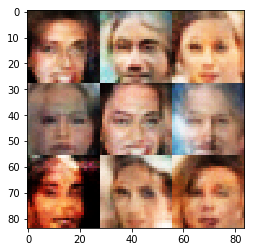

Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.3142
Epoch 1/1... Discriminator Loss: 0.6496... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.4461
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 2.7929
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 0.7516... Generator Loss: 1.5845
Epoch 1/1... Discriminator Loss: 0.6934... Generator Loss: 0.9823
Epoch 1/1... Discriminator Loss: 0.2648... Generator Loss: 2.2809
Epoch 1/1... Discriminator Loss: 0.6847... Generator Loss: 1.6646


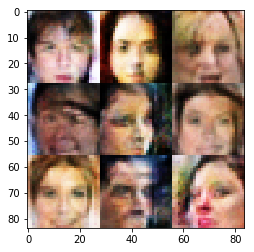

Epoch 1/1... Discriminator Loss: 0.3880... Generator Loss: 1.9505
Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 0.5268... Generator Loss: 1.2736
Epoch 1/1... Discriminator Loss: 0.3496... Generator Loss: 2.5162
Epoch 1/1... Discriminator Loss: 0.3837... Generator Loss: 1.8190
Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 1.3422
Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 1.2497


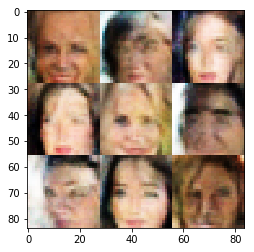

Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 1.2627
Epoch 1/1... Discriminator Loss: 0.8238... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 0.8339... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.3191
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 0.3383... Generator Loss: 1.6611


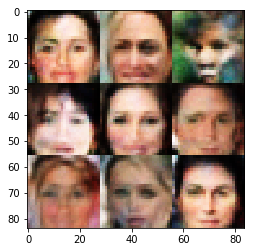

Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 0.5076... Generator Loss: 1.6636
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 0.4720
Epoch 1/1... Discriminator Loss: 0.4633... Generator Loss: 1.2253
Epoch 1/1... Discriminator Loss: 0.6619... Generator Loss: 1.4167
Epoch 1/1... Discriminator Loss: 0.4547... Generator Loss: 1.3871
Epoch 1/1... Discriminator Loss: 0.3884... Generator Loss: 1.3586
Epoch 1/1... Discriminator Loss: 0.4300... Generator Loss: 1.5499
Epoch 1/1... Discriminator Loss: 0.7876... Generator Loss: 3.9258
Epoch 1/1... Discriminator Loss: 0.1574... Generator Loss: 2.5831


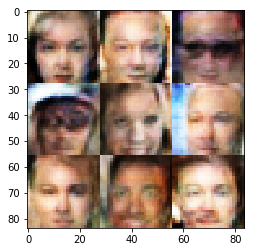

Epoch 1/1... Discriminator Loss: 0.3506... Generator Loss: 1.4985
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 0.8240... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.0365
Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 1.3303
Epoch 1/1... Discriminator Loss: 0.3646... Generator Loss: 1.8753
Epoch 1/1... Discriminator Loss: 1.9067... Generator Loss: 1.4699
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 0.6000... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 0.8519


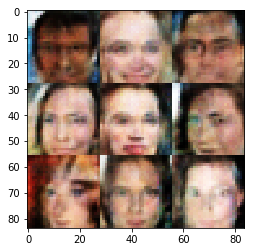

Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.4525
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.5124
Epoch 1/1... Discriminator Loss: 0.6831... Generator Loss: 1.9536
Epoch 1/1... Discriminator Loss: 0.1589... Generator Loss: 2.7051
Epoch 1/1... Discriminator Loss: 0.1430... Generator Loss: 2.6462
Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 1.1710
Epoch 1/1... Discriminator Loss: 0.2783... Generator Loss: 2.5160
Epoch 1/1... Discriminator Loss: 0.2100... Generator Loss: 3.0907
Epoch 1/1... Discriminator Loss: 0.4606... Generator Loss: 1.7715


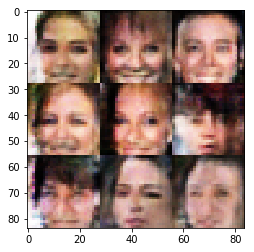

Epoch 1/1... Discriminator Loss: 0.3667... Generator Loss: 1.4828
Epoch 1/1... Discriminator Loss: 0.8537... Generator Loss: 1.7368
Epoch 1/1... Discriminator Loss: 0.6663... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 0.4812... Generator Loss: 1.3238
Epoch 1/1... Discriminator Loss: 0.3917... Generator Loss: 1.6221
Epoch 1/1... Discriminator Loss: 0.3091... Generator Loss: 3.9054
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.5441
Epoch 1/1... Discriminator Loss: 0.2725... Generator Loss: 2.0996
Epoch 1/1... Discriminator Loss: 0.6723... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 3.5352


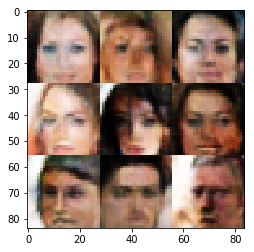

Epoch 1/1... Discriminator Loss: 0.4413... Generator Loss: 1.8617
Epoch 1/1... Discriminator Loss: 1.6085... Generator Loss: 0.2738
Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 0.8872... Generator Loss: 1.4640
Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.2845
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.4561
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.3267


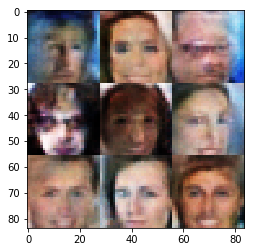

Epoch 1/1... Discriminator Loss: 0.7925... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 1.2343
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.4135
Epoch 1/1... Discriminator Loss: 0.6511... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 1.2193
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.3558
Epoch 1/1... Discriminator Loss: 0.6014... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.7256


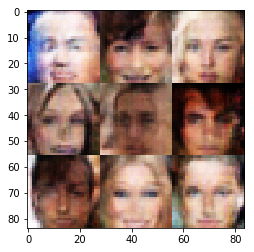

Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 1.0491
Epoch 1/1... Discriminator Loss: 0.7342... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 0.7836... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 0.8926... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.4077
Epoch 1/1... Discriminator Loss: 0.7788... Generator Loss: 1.1131


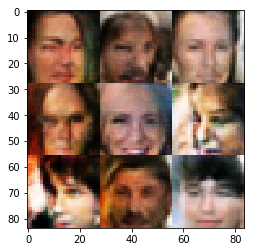

Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.4740
Epoch 1/1... Discriminator Loss: 1.6451... Generator Loss: 0.2475
Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.3728
Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 3.6528
Epoch 1/1... Discriminator Loss: 0.6316... Generator Loss: 1.0516
Epoch 1/1... Discriminator Loss: 0.2453... Generator Loss: 1.8210
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 0.4381
Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 1.9815
Epoch 1/1... Discriminator Loss: 0.1930... Generator Loss: 2.1472


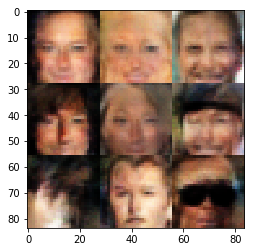

Epoch 1/1... Discriminator Loss: 0.2447... Generator Loss: 2.0510
Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 0.5362
Epoch 1/1... Discriminator Loss: 0.1580... Generator Loss: 2.8309
Epoch 1/1... Discriminator Loss: 0.7387... Generator Loss: 1.1472
Epoch 1/1... Discriminator Loss: 0.6197... Generator Loss: 1.0994
Epoch 1/1... Discriminator Loss: 0.4140... Generator Loss: 1.7820
Epoch 1/1... Discriminator Loss: 0.5839... Generator Loss: 5.6321
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.4399
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.4398


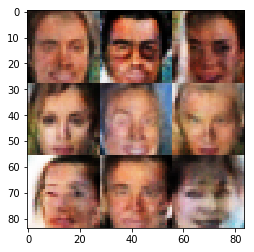

Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 0.6219... Generator Loss: 1.2665
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.3588
Epoch 1/1... Discriminator Loss: 0.5810... Generator Loss: 1.1619
Epoch 1/1... Discriminator Loss: 1.6627... Generator Loss: 0.2408
Epoch 1/1... Discriminator Loss: 1.6472... Generator Loss: 0.2829
Epoch 1/1... Discriminator Loss: 1.0287... Generator Loss: 0.6548


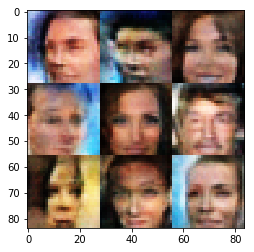

Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 0.7272... Generator Loss: 1.3634
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.3127
Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 2.9740
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 1.5504
Epoch 1/1... Discriminator Loss: 0.2269... Generator Loss: 2.2675
Epoch 1/1... Discriminator Loss: 0.7282... Generator Loss: 2.0566
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 3.6232
Epoch 1/1... Discriminator Loss: 2.6303... Generator Loss: 0.1673
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.4997


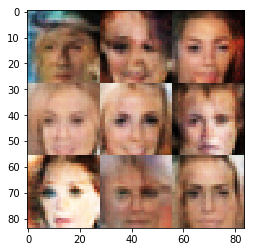

Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.4035
Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 1.1890
Epoch 1/1... Discriminator Loss: 0.7764... Generator Loss: 1.2561
Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 0.5274... Generator Loss: 0.9946
Epoch 1/1... Discriminator Loss: 0.8150... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.3854


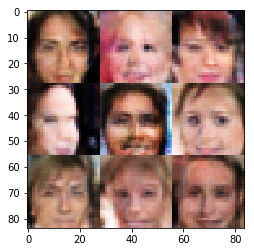

Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 0.9804
Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 1.7748
Epoch 1/1... Discriminator Loss: 2.3591... Generator Loss: 0.1419
Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 3.5264
Epoch 1/1... Discriminator Loss: 0.3875... Generator Loss: 1.8041
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.3995
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 0.6196


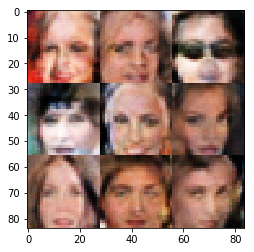

Epoch 1/1... Discriminator Loss: 0.3089... Generator Loss: 1.8304
Epoch 1/1... Discriminator Loss: 0.7538... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 0.4198... Generator Loss: 1.3818
Epoch 1/1... Discriminator Loss: 0.2796... Generator Loss: 2.3299
Epoch 1/1... Discriminator Loss: 0.4483... Generator Loss: 1.7038
Epoch 1/1... Discriminator Loss: 0.2930... Generator Loss: 1.5980
Epoch 1/1... Discriminator Loss: 0.3880... Generator Loss: 1.5130
Epoch 1/1... Discriminator Loss: 0.2773... Generator Loss: 3.0998
Epoch 1/1... Discriminator Loss: 0.4960... Generator Loss: 1.5278
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.4010


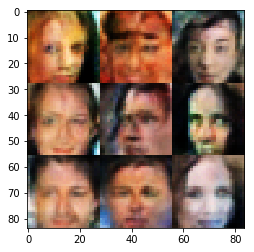

Epoch 1/1... Discriminator Loss: 0.2847... Generator Loss: 2.1359
Epoch 1/1... Discriminator Loss: 0.2852... Generator Loss: 1.6128
Epoch 1/1... Discriminator Loss: 0.5012... Generator Loss: 1.2411
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 2.7251
Epoch 1/1... Discriminator Loss: 0.6268... Generator Loss: 1.0873
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 0.5611
Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 0.7569... Generator Loss: 1.1340
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 0.5512


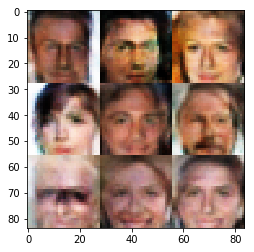

Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 0.0867... Generator Loss: 3.1012
Epoch 1/1... Discriminator Loss: 0.5037... Generator Loss: 1.1565
Epoch 1/1... Discriminator Loss: 0.3322... Generator Loss: 1.5216
Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 0.2540
Epoch 1/1... Discriminator Loss: 0.1098... Generator Loss: 4.6971
Epoch 1/1... Discriminator Loss: 1.5786... Generator Loss: 0.2768
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.5741
Epoch 1/1... Discriminator Loss: 0.7653... Generator Loss: 1.5266


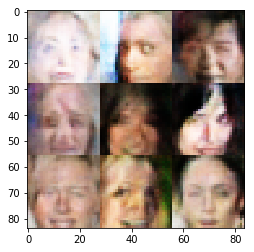

Epoch 1/1... Discriminator Loss: 0.6915... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.4075
Epoch 1/1... Discriminator Loss: 1.6580... Generator Loss: 0.2919
Epoch 1/1... Discriminator Loss: 0.6978... Generator Loss: 2.6300
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.5290
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 1.1499
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 0.7748... Generator Loss: 1.0615


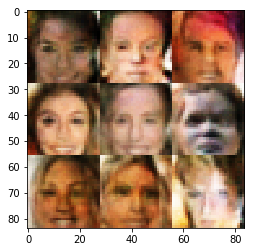

Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 0.8602... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 0.6854... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 0.8353... Generator Loss: 1.0046
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 1.0147
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 0.9260


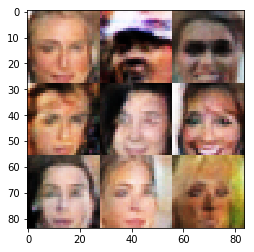

Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 1.1458
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.3150
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.5510
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 0.5225
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 0.6619... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 2.8023


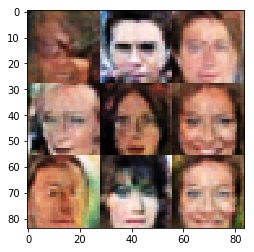

Epoch 1/1... Discriminator Loss: 0.3127... Generator Loss: 1.9548
Epoch 1/1... Discriminator Loss: 1.7032... Generator Loss: 2.3065
Epoch 1/1... Discriminator Loss: 1.8736... Generator Loss: 0.1851
Epoch 1/1... Discriminator Loss: 0.5714... Generator Loss: 1.0838
Epoch 1/1... Discriminator Loss: 2.3969... Generator Loss: 0.1433
Epoch 1/1... Discriminator Loss: 0.9032... Generator Loss: 2.4246
Epoch 1/1... Discriminator Loss: 0.3209... Generator Loss: 1.8795
Epoch 1/1... Discriminator Loss: 0.8283... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 0.5734... Generator Loss: 3.1610
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 0.8920


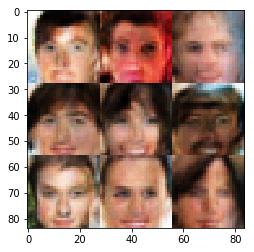

Epoch 1/1... Discriminator Loss: 2.2375... Generator Loss: 0.1484
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 0.5075... Generator Loss: 1.1680
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 1.6945
Epoch 1/1... Discriminator Loss: 1.9188... Generator Loss: 0.2253
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 1.1560


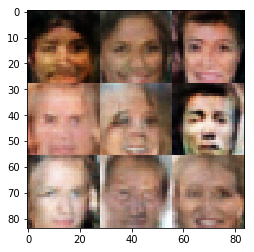

Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.5017
Epoch 1/1... Discriminator Loss: 0.7829... Generator Loss: 0.9540
Epoch 1/1... Discriminator Loss: 0.7376... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 1.1957
Epoch 1/1... Discriminator Loss: 0.3718... Generator Loss: 2.9319
Epoch 1/1... Discriminator Loss: 2.6002... Generator Loss: 5.0688
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 0.8462... Generator Loss: 3.0612
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.3713
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 2.6556


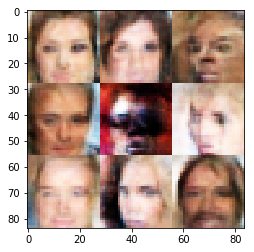

Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.5216
Epoch 1/1... Discriminator Loss: 0.7347... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 0.7262... Generator Loss: 1.0891
Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.2641
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 0.9268... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 0.9214


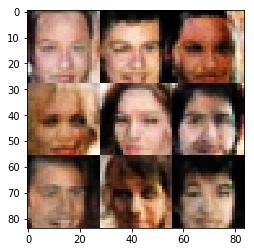

Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 0.5346
Epoch 1/1... Discriminator Loss: 0.7112... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 0.5050
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.4781
Epoch 1/1... Discriminator Loss: 0.3732... Generator Loss: 1.3593
Epoch 1/1... Discriminator Loss: 3.5407... Generator Loss: 0.0492
Epoch 1/1... Discriminator Loss: 1.7706... Generator Loss: 0.2278
Epoch 1/1... Discriminator Loss: 0.2000... Generator Loss: 2.4522
Epoch 1/1... Discriminator Loss: 0.3918... Generator Loss: 1.3230


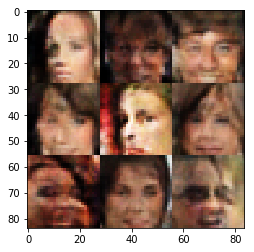

Epoch 1/1... Discriminator Loss: 1.5194... Generator Loss: 0.3382
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.3927
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 0.6163... Generator Loss: 1.0745
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.3682
Epoch 1/1... Discriminator Loss: 0.0760... Generator Loss: 4.1534
Epoch 1/1... Discriminator Loss: 0.6626... Generator Loss: 1.0314
Epoch 1/1... Discriminator Loss: 0.7827... Generator Loss: 1.3434
Epoch 1/1... Discriminator Loss: 0.1324... Generator Loss: 2.4494


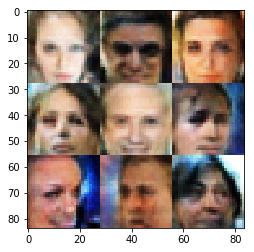

Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 0.4563... Generator Loss: 1.4163
Epoch 1/1... Discriminator Loss: 0.1598... Generator Loss: 3.8241
Epoch 1/1... Discriminator Loss: 0.7600... Generator Loss: 1.2523
Epoch 1/1... Discriminator Loss: 0.1828... Generator Loss: 2.6022
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 1.4918
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 0.7873... Generator Loss: 1.1764
Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 0.9916


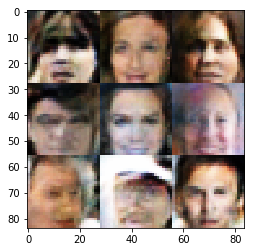

Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 1.0088
Epoch 1/1... Discriminator Loss: 0.3920... Generator Loss: 1.3903
Epoch 1/1... Discriminator Loss: 0.6910... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.4635
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.4785
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.3438
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.4625
Epoch 1/1... Discriminator Loss: 0.6346... Generator Loss: 1.0701


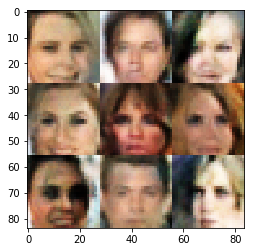

Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 1.0153
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 0.7325... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 1.0356
Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 1.7393
Epoch 1/1... Discriminator Loss: 2.5336... Generator Loss: 0.0995
Epoch 1/1... Discriminator Loss: 0.7556... Generator Loss: 1.4248
Epoch 1/1... Discriminator Loss: 0.4574... Generator Loss: 1.1172


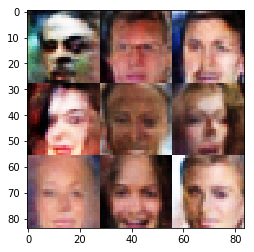

Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.3992
Epoch 1/1... Discriminator Loss: 0.1724... Generator Loss: 4.0349
Epoch 1/1... Discriminator Loss: 0.2604... Generator Loss: 1.9479
Epoch 1/1... Discriminator Loss: 0.5783... Generator Loss: 1.5073
Epoch 1/1... Discriminator Loss: 0.2776... Generator Loss: 1.8433
Epoch 1/1... Discriminator Loss: 0.4770... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 1.5589... Generator Loss: 1.5669
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 0.8340... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 0.8841


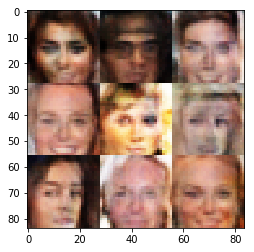

Epoch 1/1... Discriminator Loss: 0.7626... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.4788
Epoch 1/1... Discriminator Loss: 0.2864... Generator Loss: 1.7677
Epoch 1/1... Discriminator Loss: 0.2322... Generator Loss: 2.1717


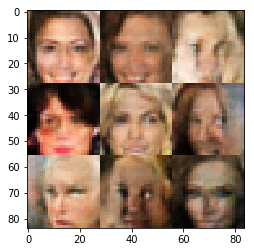

Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 0.4442... Generator Loss: 3.5132
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 0.4957
Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 1.3538
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 1.9869
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 1.4391
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.3345


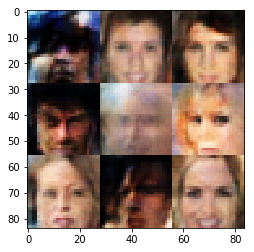

Epoch 1/1... Discriminator Loss: 1.9728... Generator Loss: 0.1849
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 0.6677... Generator Loss: 1.2178
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.4677
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.3882
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.4753
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.1871
Epoch 1/1... Discriminator Loss: 0.6294... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 0.6406... Generator Loss: 1.2116


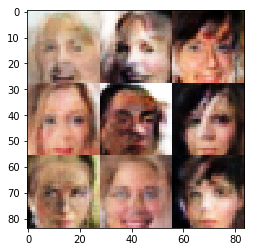

Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.4553
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.4985
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.3888
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.6492... Generator Loss: 0.4661
Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.4491
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.5014
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.5503


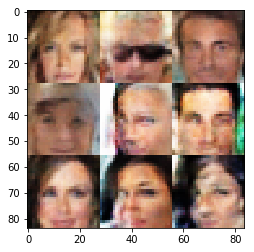

Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.4310
Epoch 1/1... Discriminator Loss: 0.9212... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 1.8366
Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 1.0810
Epoch 1/1... Discriminator Loss: 0.2297... Generator Loss: 2.3611
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.5161
Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 2.6581
Epoch 1/1... Discriminator Loss: 0.8482... Generator Loss: 1.1430
Epoch 1/1... Discriminator Loss: 0.7118... Generator Loss: 1.6188
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.4658


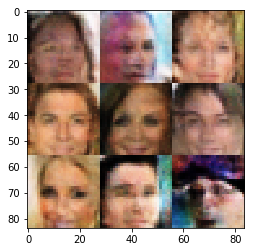

Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.4556
Epoch 1/1... Discriminator Loss: 0.8076... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.4694
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 1.2394
Epoch 1/1... Discriminator Loss: 0.8004... Generator Loss: 1.0908
Epoch 1/1... Discriminator Loss: 0.8325... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.3579


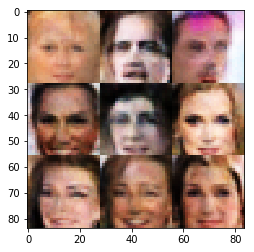

Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 0.4307... Generator Loss: 1.6507
Epoch 1/1... Discriminator Loss: 0.8338... Generator Loss: 4.7576
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.4083
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 3.1147
Epoch 1/1... Discriminator Loss: 0.2658... Generator Loss: 1.8613
Epoch 1/1... Discriminator Loss: 0.5983... Generator Loss: 1.0228
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.3151
Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 0.9041


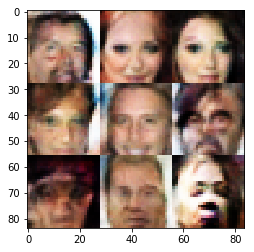

Epoch 1/1... Discriminator Loss: 0.0861... Generator Loss: 3.3174
Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 0.1042... Generator Loss: 3.9903
Epoch 1/1... Discriminator Loss: 0.5121... Generator Loss: 1.4721
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 1.0895


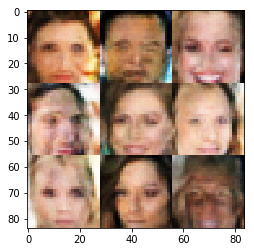

Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.3080
Epoch 1/1... Discriminator Loss: 0.0614... Generator Loss: 3.6807
Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 0.3302
Epoch 1/1... Discriminator Loss: 0.9118... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.3770
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 0.8994... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 0.7471... Generator Loss: 1.0607
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.4195


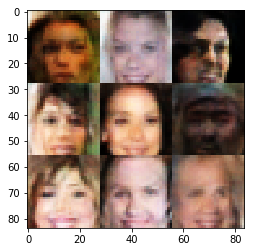

Epoch 1/1... Discriminator Loss: 0.7821... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 0.3709... Generator Loss: 2.1825
Epoch 1/1... Discriminator Loss: 2.9502... Generator Loss: 3.2886
Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 1.0338
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 2.8062
Epoch 1/1... Discriminator Loss: 0.8392... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 0.6677... Generator Loss: 1.2402


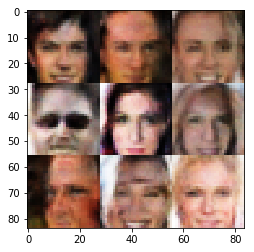

Epoch 1/1... Discriminator Loss: 0.8242... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.3367
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.4438
Epoch 1/1... Discriminator Loss: 1.5604... Generator Loss: 0.3408
Epoch 1/1... Discriminator Loss: 0.2062... Generator Loss: 2.0347
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 0.3461... Generator Loss: 2.1948
Epoch 1/1... Discriminator Loss: 2.6113... Generator Loss: 0.0963
Epoch 1/1... Discriminator Loss: 0.2015... Generator Loss: 3.4600


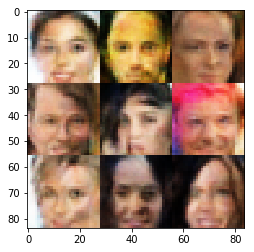

Epoch 1/1... Discriminator Loss: 0.6901... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.5464... Generator Loss: 0.3667
Epoch 1/1... Discriminator Loss: 0.1357... Generator Loss: 3.0268
Epoch 1/1... Discriminator Loss: 0.5712... Generator Loss: 0.9899
Epoch 1/1... Discriminator Loss: 1.5723... Generator Loss: 0.3037
Epoch 1/1... Discriminator Loss: 0.4527... Generator Loss: 1.4072
Epoch 1/1... Discriminator Loss: 0.3160... Generator Loss: 2.1887
Epoch 1/1... Discriminator Loss: 0.5632... Generator Loss: 1.2972
Epoch 1/1... Discriminator Loss: 0.5659... Generator Loss: 1.2047
Epoch 1/1... Discriminator Loss: 0.1883... Generator Loss: 2.3674


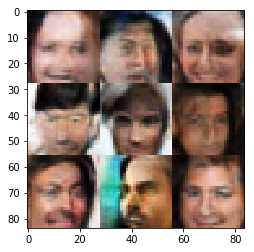

Epoch 1/1... Discriminator Loss: 0.1300... Generator Loss: 3.3578
Epoch 1/1... Discriminator Loss: 0.0879... Generator Loss: 4.2640
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 0.2295... Generator Loss: 2.2895
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 0.6122... Generator Loss: 1.3207
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.5300
Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 1.6619
Epoch 1/1... Discriminator Loss: 0.3015... Generator Loss: 3.5110
Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 0.9244


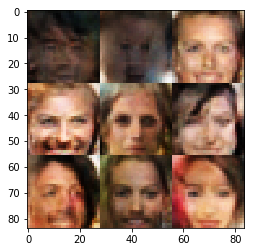

Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.4128
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.4247
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.4775
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.3803
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.4563
Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 1.1583
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.4602


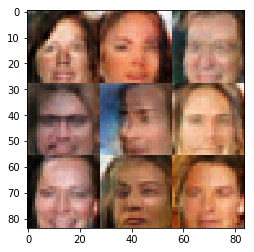

Epoch 1/1... Discriminator Loss: 0.2279... Generator Loss: 2.2610
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 0.3396... Generator Loss: 2.4461
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.3609
Epoch 1/1... Discriminator Loss: 0.1173... Generator Loss: 3.9423
Epoch 1/1... Discriminator Loss: 0.1800... Generator Loss: 3.0084
Epoch 1/1... Discriminator Loss: 2.6333... Generator Loss: 3.2876
Epoch 1/1... Discriminator Loss: 0.2851... Generator Loss: 1.8766
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 0.5230... Generator Loss: 1.9799


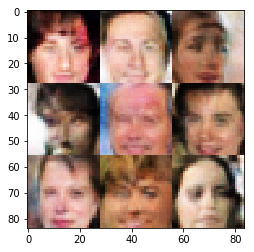

Epoch 1/1... Discriminator Loss: 0.3572... Generator Loss: 1.7557
Epoch 1/1... Discriminator Loss: 0.7571... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 0.2052... Generator Loss: 2.2453
Epoch 1/1... Discriminator Loss: 0.3987... Generator Loss: 3.0042
Epoch 1/1... Discriminator Loss: 0.2660... Generator Loss: 1.9389
Epoch 1/1... Discriminator Loss: 0.7588... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.3779
Epoch 1/1... Discriminator Loss: 0.0966... Generator Loss: 3.6186
Epoch 1/1... Discriminator Loss: 0.3607... Generator Loss: 1.4974
Epoch 1/1... Discriminator Loss: 0.1903... Generator Loss: 2.2295


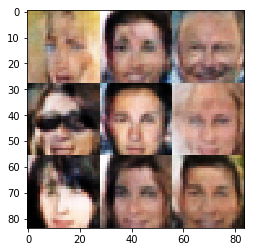

Epoch 1/1... Discriminator Loss: 0.0816... Generator Loss: 2.9702
Epoch 1/1... Discriminator Loss: 0.1587... Generator Loss: 2.4394
Epoch 1/1... Discriminator Loss: 0.2580... Generator Loss: 3.5250
Epoch 1/1... Discriminator Loss: 0.6506... Generator Loss: 1.5166
Epoch 1/1... Discriminator Loss: 0.5176... Generator Loss: 1.2606
Epoch 1/1... Discriminator Loss: 0.5719... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 0.3171... Generator Loss: 1.6097
Epoch 1/1... Discriminator Loss: 0.6267... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 3.1214
Epoch 1/1... Discriminator Loss: 0.2600... Generator Loss: 1.9469


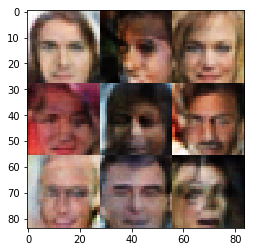

Epoch 1/1... Discriminator Loss: 0.3677... Generator Loss: 1.5917
Epoch 1/1... Discriminator Loss: 2.0528... Generator Loss: 0.1816
Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 2.7520
Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 1.4937
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 0.0717... Generator Loss: 3.4737
Epoch 1/1... Discriminator Loss: 0.3106... Generator Loss: 1.7636
Epoch 1/1... Discriminator Loss: 1.4883... Generator Loss: 0.3760
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 0.9813
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 0.7367


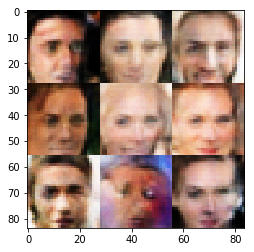

Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 1.5114
Epoch 1/1... Discriminator Loss: 0.4731... Generator Loss: 1.4952
Epoch 1/1... Discriminator Loss: 0.7412... Generator Loss: 1.5388
Epoch 1/1... Discriminator Loss: 0.7835... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 0.3683... Generator Loss: 1.7997
Epoch 1/1... Discriminator Loss: 0.7523... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 0.5359
Epoch 1/1... Discriminator Loss: 0.4797... Generator Loss: 1.3426
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 1.2644
Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 1.0956


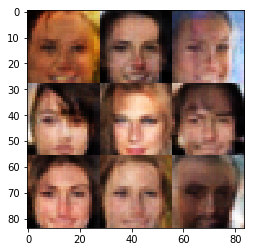

Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.4665
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 3.7379
Epoch 1/1... Discriminator Loss: 0.7151... Generator Loss: 1.5703
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 0.9983
Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 1.1316
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 0.6191


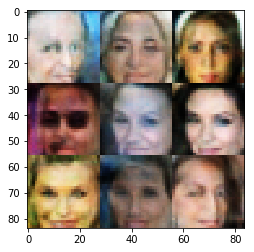

Epoch 1/1... Discriminator Loss: 0.7591... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 1.3061
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 0.7606


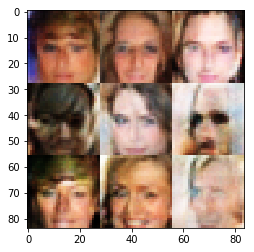

In [14]:
batch_size = 16
z_dim = 128
learning_rate = 0.0009
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.